# 2D UNet

## Environment Setup

In [94]:
import time
import random 
import requests
import numpy as np
import pandas as pd

import keras
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D, SpatialDropout2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

""" Settings for visuals"""
alpha = 0.75

## Gather Data

In [95]:
# File names to save training data
X_train_path = 'X_train.npy'
Y_train_path = 'Y_train.npy'

In [21]:
# Download training data from S3 bucket
# NOTE: You should only need to run this once. 
s3_url = 'https://s3.amazonaws.com/com.bsethwalker/cs109b/luna16/2d/'

r = requests.get(s3_url+X_train_path, allow_redirects=True)
open(X_train_path, 'wb').write(r.content)

r = requests.get(s3_url+Y_train_path, allow_redirects=True)
open(Y_train_path, 'wb').write(r.content);

In [4]:
# Load full training set
X_train_full = np.load(X_train_path)
Y_train_full = np.load(Y_train_path)

#### Resize the images

In [5]:
# Images Dimensions
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1 # grayscale would be 1, 3 is RGB

In [6]:
# Resize the images to the defined sizes
X_train_resized = []
Y_train_resized = []

# Preprocess Images
for i in range(len(X_train_full)):
    X_train_resized.append(resize(X_train_full[i], 
                                  (IMG_WIDTH, IMG_HEIGHT),
                                  mode = 'constant', 
                                  preserve_range = True))
    
    Y_train_resized.append(resize(Y_train_full[i], 
                                  (IMG_WIDTH, IMG_HEIGHT),
                                  mode = 'constant', 
                                  preserve_range = True))

In [7]:
# Convert to numpy arrays 
X_train_full = np.array(X_train_resized)
Y_train_full = np.array(Y_train_resized)

# Free some memory
del X_train_resized, Y_train_resized

In [8]:
# Just make sure we have everything, and it's all the 
# expected number of dimensions.
print(len(X_train_full))  # = 888
print(X_train_full.shape) # = (888, 256, 256)
print(Y_train_full.shape) # = (888, 256, 256)

888
(888, 256, 256)
(888, 256, 256)


## Create Test and Training Data

#### Split into Test and Validation

In [9]:
# Split our training data into test/validation
VAL_SIZE = 75  # Size of validation set

N = X_train_full.shape[0]

msk = np.random.choice(range(N), VAL_SIZE, replace = False)

X_train = X_train_full[[i for i in range(N) if i not in msk]]
Y_train = Y_train_full[[i for i in range(N) if i not in msk]]

X_val = X_train_full[msk]
Y_val = Y_train_full[msk]

print("There are %d training and %d valdiation records out of %d total." 
      % (X_train.shape[0], X_val.shape[0], N))

There are 813 training and 75 valdiation records out of 888 total.


In [10]:
# Free up memory
del X_train_full, Y_train_full

In [11]:
# Use expand_dims to add the channel dimension
X_train = np.expand_dims(X_train, axis=3)
Y_train = np.expand_dims(Y_train, axis=3)

X_val = np.expand_dims(X_val, axis=3)
Y_val = np.expand_dims(Y_val, axis=3)

In [96]:
# Make sure things are the correct dimensions.
print(Y_val.shape)   # = (75, 256, 256, 1)
print(X_train.shape) # = (813, 256, 256, 1)

(75, 256, 256, 1)
(813, 256, 256, 1)


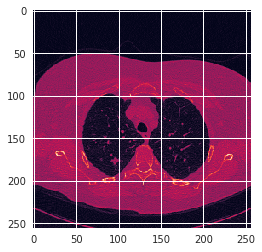

In [97]:
# Take a look at an image and it's corresponding mask, 
# just for a sanity check. 
idx = 0

plt.imshow(np.squeeze(X_train[idx]));

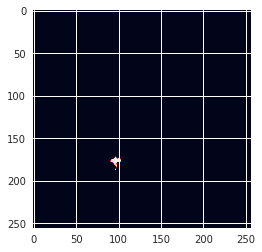

In [98]:
plt.imshow(np.squeeze(Y_train[idx]));

## Define Model

### Model Hyper-Parameters

In [102]:
theta = { 'batch_size'     : 16
         ,'epochs'         : 100
         
         ,'dropout_rate'  : 0.5 
         
         ,'filter_cnt'     : 32
         ,'activation'     :'relu'
         ,'padding'        :'same'
         ,'out_activation' :'sigmoid'
         ,'learning_rate'  :1e-5}

### Model Definition

In [ ]:
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    
    return -dice_coef(y_true, y_pred)

In [100]:
def UNET(theta):
    inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    
    norm = Lambda(lambda x: x+1024 / (3071+1024))(inputs) # Normalize to [0,1]
    
    conv1 = Conv2D(theta['filter_cnt'], (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(norm)
    conv1 = BatchNormalization(axis = 1)(conv1)
    conv1 = Conv2D(theta['filter_cnt'], (3, 3), 
                   activation='relu', 
                   padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(theta['filter_cnt']*2, (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(pool1)
    conv2 = BatchNormalization(axis = 1)(conv2)
    conv2 = Conv2D(theta['filter_cnt']*2, (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(theta['filter_cnt']*4, (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(pool2)
    conv3 = BatchNormalization(axis = 1)(conv3)
    conv3 = Conv2D(theta['filter_cnt']*4, (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(theta['filter_cnt']*8, (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(pool3)
    conv4 = BatchNormalization(axis = 1)(conv4)
    conv4 = Conv2D(theta['filter_cnt']*8, (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(theta['filter_cnt']*16, (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(pool4)
    conv5 = BatchNormalization(axis = 1)(conv5)
    conv5 = Conv2D(theta['filter_cnt']*16, (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = SpatialDropout2D(theta['dropout_rate'])(up6)
    conv6 = Conv2D(theta['filter_cnt']*8, (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(conv6)
    conv6 = Conv2D(theta['filter_cnt']*8, (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = SpatialDropout2D(theta['dropout_rate'])(up7)
    conv7 = Conv2D(theta['filter_cnt']*4, (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(conv7)
    conv7 = Conv2D(theta['filter_cnt']*4, (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = SpatialDropout2D(theta['dropout_rate'])(up8)
    conv8 = Conv2D(theta['filter_cnt']*2, (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(conv8)
    conv8 = Conv2D(theta['filter_cnt']*2, (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = SpatialDropout2D(theta['dropout_rate'])(up9)
    conv9 = Conv2D(theta['filter_cnt'], (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(conv9)
    conv9 = Conv2D(theta['filter_cnt'], (3, 3), 
                   activation=theta['activation'], 
                   padding=theta['padding'])(conv9)
    conv10 = Conv2D(1, (1, 1), 
                    activation=theta['activation'])(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    
    model.compile(optimizer=Adam(lr=theta['learning_rate']), 
                  loss=dice_coef_loss, 
                  metrics=[dice_coef])
    
    return model

In [101]:
model = None #'unet2.h5' # Set to None for new model

if model:
    model = load_model(model, 
                       custom_objects={'dice_coef_loss': dice_coef_loss, 
                                       'dice_coef':      dice_coef})
else:
    model = UNET(theta)

In [103]:
'''
NOTE: It takes about 1 hour to train 100 epochs, 
while running on Jupyter Hub. '''

# Track when training starts.
start = time.time()

model.fit(X_train, Y_train, 
          validation_split = 0.1, 
          batch_size = theta['batch_size'], 
          epochs = theta['epochs'])

# See how long it took to train the model
done = time.time()
elapsed = done - start
m, s = divmod(elapsed, 60)

print("Training completed in %.d minutes and %d seconds. " % (m, s))

''' Save the model '''
# Set to None or filename. If none, the model won't save.
filename = 'UNet4' #None

if filename:
    model.save(filename+'.h5')

Train on 731 samples, validate on 82 samples
Epoch 1/100
731/731 [==============================] - 42s 57ms/step - loss: -0.0010 - dice_coef: 0.0010 - val_loss: -9.6687e-04 - val_dice_coef: 9.6687e-04
Epoch 2/100
731/731 [==============================] - 39s 54ms/step - loss: -0.0011 - dice_coef: 0.0011 - val_loss: -0.0013 - val_dice_coef: 0.0013
Epoch 3/100
731/731 [==============================] - 39s 54ms/step - loss: -0.0015 - dice_coef: 0.0015 - val_loss: -0.0022 - val_dice_coef: 0.0022
Epoch 4/100
731/731 [==============================] - 39s 54ms/step - loss: -0.0021 - dice_coef: 0.0021 - val_loss: -0.0144 - val_dice_coef: 0.0144
Epoch 5/100
731/731 [==============================] - 40s 54ms/step - loss: -0.0036 - dice_coef: 0.0036 - val_loss: -0.0206 - val_dice_coef: 0.0206
Epoch 6/100
731/731 [==============================] - 39s 54ms/step - loss: -0.0102 - dice_coef: 0.0102 - val_loss: -0.0325 - val_dice_coef: 0.0325
Epoch 7/100
731/731 [==============================] 

731/731 [==============================] - 39s 54ms/step - loss: -1.6258 - dice_coef: 1.6258 - val_loss: -1.5723 - val_dice_coef: 1.5723
Epoch 56/100
731/731 [==============================] - 39s 54ms/step - loss: -1.5523 - dice_coef: 1.5523 - val_loss: -1.6383 - val_dice_coef: 1.6383
Epoch 57/100
731/731 [==============================] - 39s 54ms/step - loss: -1.6036 - dice_coef: 1.6036 - val_loss: -1.6119 - val_dice_coef: 1.6119
Epoch 58/100
731/731 [==============================] - 39s 54ms/step - loss: -1.4943 - dice_coef: 1.4943 - val_loss: -1.5680 - val_dice_coef: 1.5680
Epoch 59/100
731/731 [==============================] - 39s 54ms/step - loss: -1.5294 - dice_coef: 1.5294 - val_loss: -1.6216 - val_dice_coef: 1.6216
Epoch 60/100
731/731 [==============================] - 39s 54ms/step - loss: -1.6333 - dice_coef: 1.6333 - val_loss: -1.6949 - val_dice_coef: 1.6949
Epoch 61/100
731/731 [==============================] - 39s 54ms/step - loss: -1.6545 - dice_coef: 1.6545 - val_l

In [60]:
Y_hat = model.predict(X_val)

#### Visualize Predictions

In [113]:
idx = 21

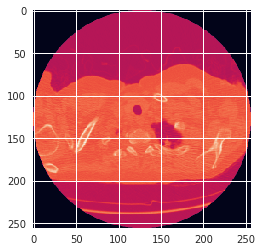

In [105]:
plt.imshow(np.squeeze(X_val[idx]));

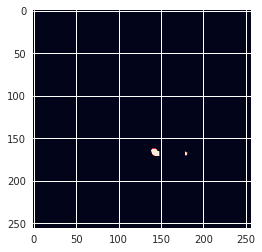

In [112]:
plt.imshow(np.squeeze(Y_val[21]));

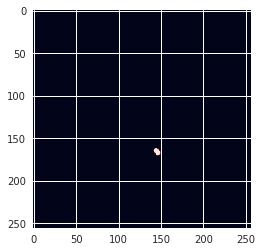

In [114]:
plt.imshow(np.squeeze(Y_hat[idx]));